In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [3]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [4]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0))
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
    return str(index[0]), labels[str(index[0])][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225])  + torch.Tensor([0.485, 0.456, 0.406])

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

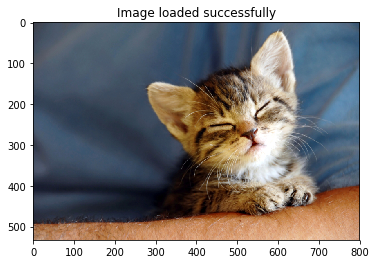

In [5]:
kitten_1 = load_image("./images/kitten_1.jpg")

In [6]:
vgg = models.vgg16(pretrained=True)

In [7]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [8]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [9]:
kitten_2 = normalize(kitten_1)
print(predict(kitten_2))

('281', 'tabby')


In [10]:
modulelist = list(vgg.features.modules())

In [11]:
print(modulelist)

[Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
 

# Output of various layers

In [12]:
def layer_outputs(image):
    outputs = []
    names = []
    for layer in modulelist[1:]:
    #     print(layer)
    #     print('----------------------------------------------')
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (30, 100)

    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=30)

    plt.savefig('layer_outputs.jpg', bbox_inches='tight')

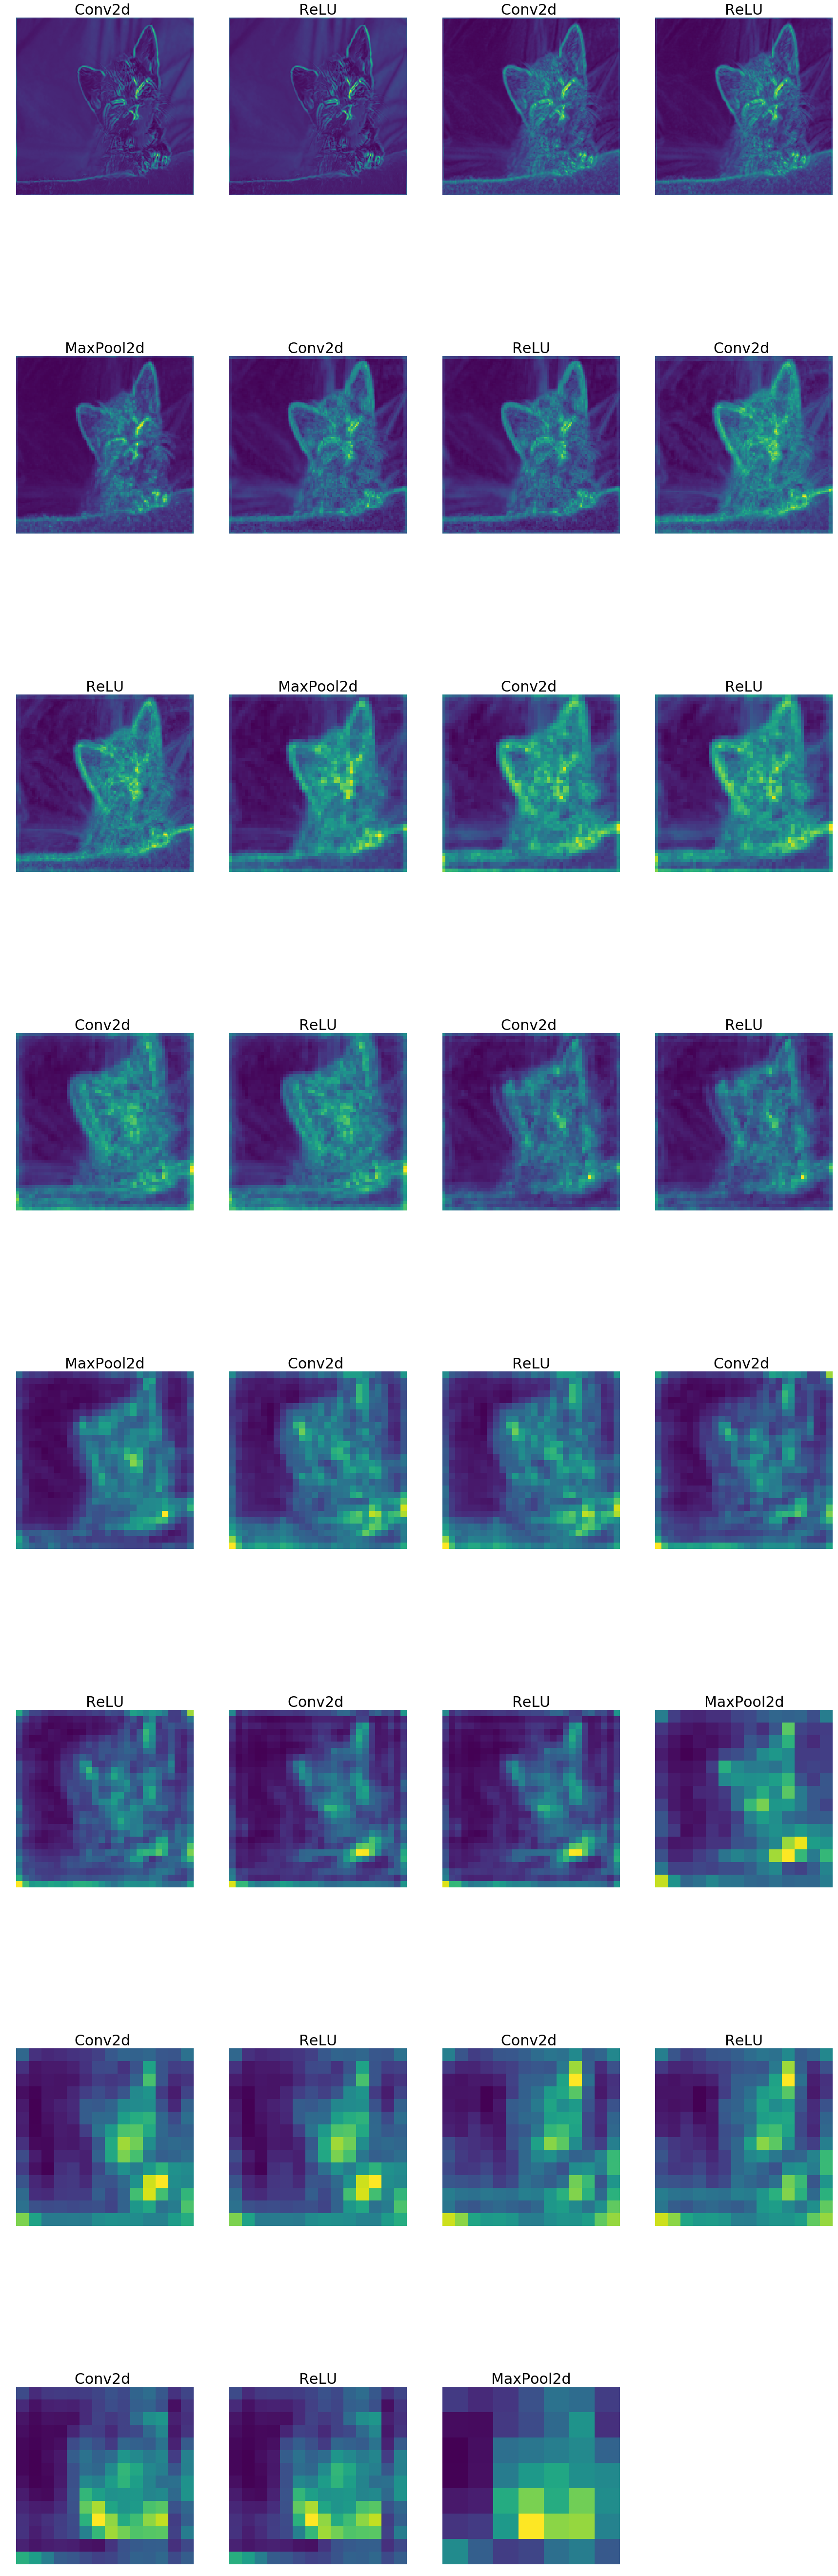

In [14]:
layer_outputs(kitten_2)

# Visualize weights

In [15]:
def visualize_weights(image, layer):
    weight_used = []
    for w in vgg.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight_used.append(w.weight.data)

    filters = []
    for i in range(weight_used[layer].shape[0]):
        filters.append(weight_used[layer][i,:,:,:].sum(dim=0))
        filters[i].div(weight_used[layer].shape[1])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)
    for i in range(len(filters)):
        a = fig.add_subplot(np.sqrt(weight_used[layer].shape[0])+1,np.sqrt(weight_used[layer].shape[0])+1,i+1)
        imgplot = plt.imshow(filters[i])
        plt.axis('off')

In [17]:
# First conv layer filters
visualize_weights(kitten_2, 0)

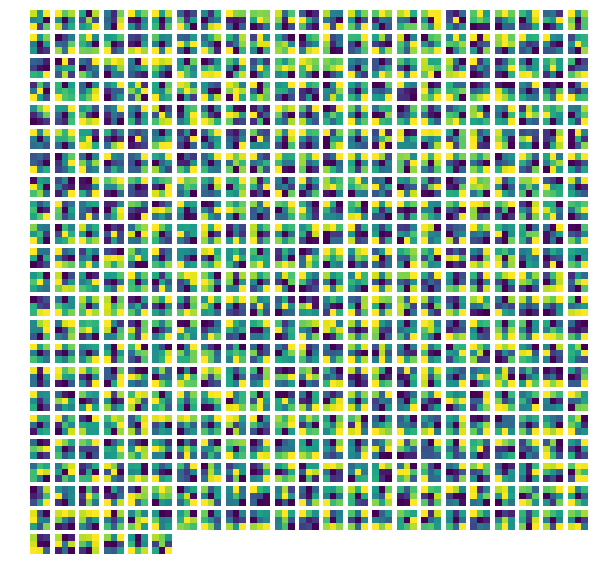

In [18]:
# Last conv layer filters
visualize_weights(kitten_2, -1)

# CNN Heatmaps : Occlusion

In [19]:
def make_heatmap(image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable(image * h_filter)
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            print("[",a, ", ",b,"] : ", heatmap[a][b])
            j += stride
            b += 1
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225])  + torch.Tensor([0.485, 0.456, 0.406])
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap
                    

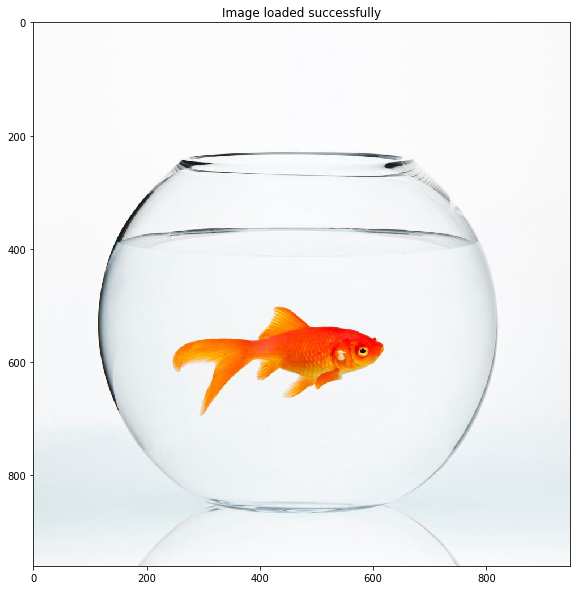

In [20]:
my_img = load_image("images/goldfish.jpg")

In [21]:
my_img = normalize(my_img)

In [22]:
predict(my_img)

('1', 'goldfish')

In [23]:
goldfish_heatmap = make_heatmap(my_img, 1, 16, 8)  # Extremely slow

/home/sarthak/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[ 0 ,  0 ] :  0.987656831741333
[ 0 ,  1 ] :  0.8472393751144409
[ 0 ,  2 ] :  0.9688547253608704
[ 0 ,  3 ] :  0.9881992340087891
[ 0 ,  4 ] :  0.800457775592804
[ 0 ,  5 ] :  0.8505943417549133
[ 0 ,  6 ] :  0.9881862998008728
[ 0 ,  7 ] :  0.9196084141731262
[ 0 ,  8 ] :  0.5224593877792358
[ 0 ,  9 ] :  0.9620131850242615
[ 0 ,  10 ] :  0.8131047487258911
[ 0 ,  11 ] :  0.6339491009712219
[ 0 ,  12 ] :  0.9830639362335205
[ 0 ,  13 ] :  0.7933967709541321
[ 0 ,  14 ] :  0.955305814743042
[ 0 ,  15 ] :  0.885471761226654
[ 0 ,  16 ] :  0.8954544067382812
[ 0 ,  17 ] :  0.8143339157104492
[ 0 ,  18 ] :  0.9582867622375488
[ 0 ,  19 ] :  0.9659290909767151
[ 0 ,  20 ] :  0.9629254341125488
[ 0 ,  21 ] :  0.9958836436271667
[ 0 ,  22 ] :  0.9173478484153748
[ 0 ,  23 ] :  0.9424653649330139
[ 0 ,  24 ] :  0.9299010634422302
[ 0 ,  25 ] :  0.8612253665924072
[ 0 ,  26 ] :  0.6232988238334656
[ 1 ,  0 ] :  0.9458432197570801
[ 1 ,  1 ] :  0.9203547239303589
[ 1 ,  2 ] :  0.83119928836822

[ 9 ,  2 ] :  0.9796187281608582
[ 9 ,  3 ] :  0.3891949951648712
[ 9 ,  4 ] :  0.8350061774253845
[ 9 ,  5 ] :  0.9439894556999207
[ 9 ,  6 ] :  0.7739163041114807
[ 9 ,  7 ] :  0.8222056031227112
[ 9 ,  8 ] :  0.08452891558408737
[ 9 ,  9 ] :  0.8080196380615234
[ 9 ,  10 ] :  0.6975485682487488
[ 9 ,  11 ] :  0.9877938628196716
[ 9 ,  12 ] :  0.7034726142883301
[ 9 ,  13 ] :  0.9242969155311584
[ 9 ,  14 ] :  0.7908288240432739
[ 9 ,  15 ] :  0.6956502199172974
[ 9 ,  16 ] :  0.9466828107833862
[ 9 ,  17 ] :  0.9783073663711548
[ 9 ,  18 ] :  0.7624369859695435
[ 9 ,  19 ] :  0.6666894555091858
[ 9 ,  20 ] :  0.9827836751937866
[ 9 ,  21 ] :  0.6890377402305603
[ 9 ,  22 ] :  0.9058462977409363
[ 9 ,  23 ] :  0.3676515221595764
[ 9 ,  24 ] :  0.7001656889915466
[ 9 ,  25 ] :  0.943028450012207
[ 9 ,  26 ] :  0.21582795679569244
[ 10 ,  0 ] :  0.9641250371932983
[ 10 ,  1 ] :  0.9726884365081787
[ 10 ,  2 ] :  0.4234965443611145
[ 10 ,  3 ] :  0.1644112914800644
[ 10 ,  4 ] :  0.8208

[ 17 ,  22 ] :  0.7143927812576294
[ 17 ,  23 ] :  0.7875415086746216
[ 17 ,  24 ] :  0.5335867404937744
[ 17 ,  25 ] :  0.8912481665611267
[ 17 ,  26 ] :  0.9362770915031433
[ 18 ,  0 ] :  0.9622405767440796
[ 18 ,  1 ] :  0.9554055333137512
[ 18 ,  2 ] :  0.9755045771598816
[ 18 ,  3 ] :  0.9943485260009766
[ 18 ,  4 ] :  0.7643817663192749
[ 18 ,  5 ] :  0.6452151536941528
[ 18 ,  6 ] :  0.9689218401908875
[ 18 ,  7 ] :  0.8564039468765259
[ 18 ,  8 ] :  0.9400607943534851
[ 18 ,  9 ] :  0.6843975782394409
[ 18 ,  10 ] :  0.34356024861335754
[ 18 ,  11 ] :  0.256989449262619
[ 18 ,  12 ] :  0.49250128865242004
[ 18 ,  13 ] :  0.9871348142623901
[ 18 ,  14 ] :  0.7951794266700745
[ 18 ,  15 ] :  0.6478397250175476
[ 18 ,  16 ] :  0.6589140295982361
[ 18 ,  17 ] :  0.2118457853794098
[ 18 ,  18 ] :  0.6435514688491821
[ 18 ,  19 ] :  0.6146249771118164
[ 18 ,  20 ] :  0.6729146242141724
[ 18 ,  21 ] :  0.9437138438224792
[ 18 ,  22 ] :  0.9738353490829468
[ 18 ,  23 ] :  0.64583760499

[ 26 ,  17 ] :  0.6970915794372559
[ 26 ,  18 ] :  0.9093914031982422
[ 26 ,  19 ] :  0.9326852560043335
[ 26 ,  20 ] :  0.414162814617157
[ 26 ,  21 ] :  0.798631489276886
[ 26 ,  22 ] :  0.8597474694252014
[ 26 ,  23 ] :  0.8817099928855896
[ 26 ,  24 ] :  0.9926248788833618
[ 26 ,  25 ] :  0.8485859036445618
[ 26 ,  26 ] :  0.9126468300819397


### TODO: Heatmap by CAM algorithm

# Class Specific Saliency Maps

In [26]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [41]:
def make_saliency_map(input, label):
    input = Variable(preprocess(input).unsqueeze(0), requires_grad=True)
    output = vgg.forward(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.numpy(), axis=2)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

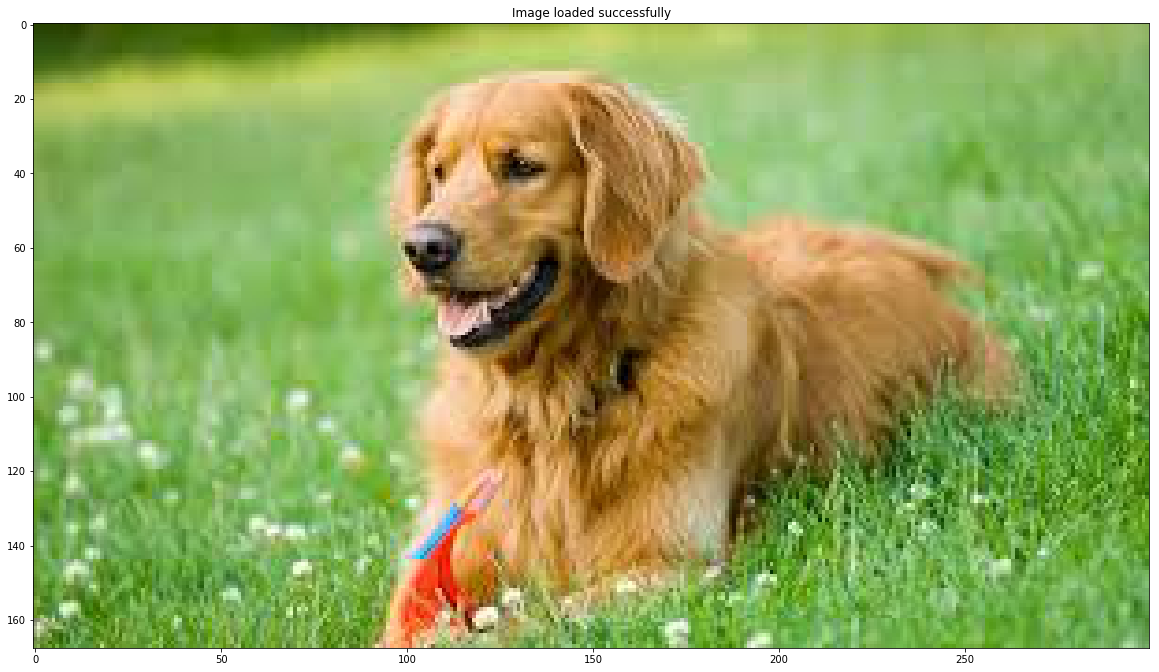

In [42]:
dog = load_image('images/retr.jpeg')
dog_sal = make_saliency_map(dog, 207)

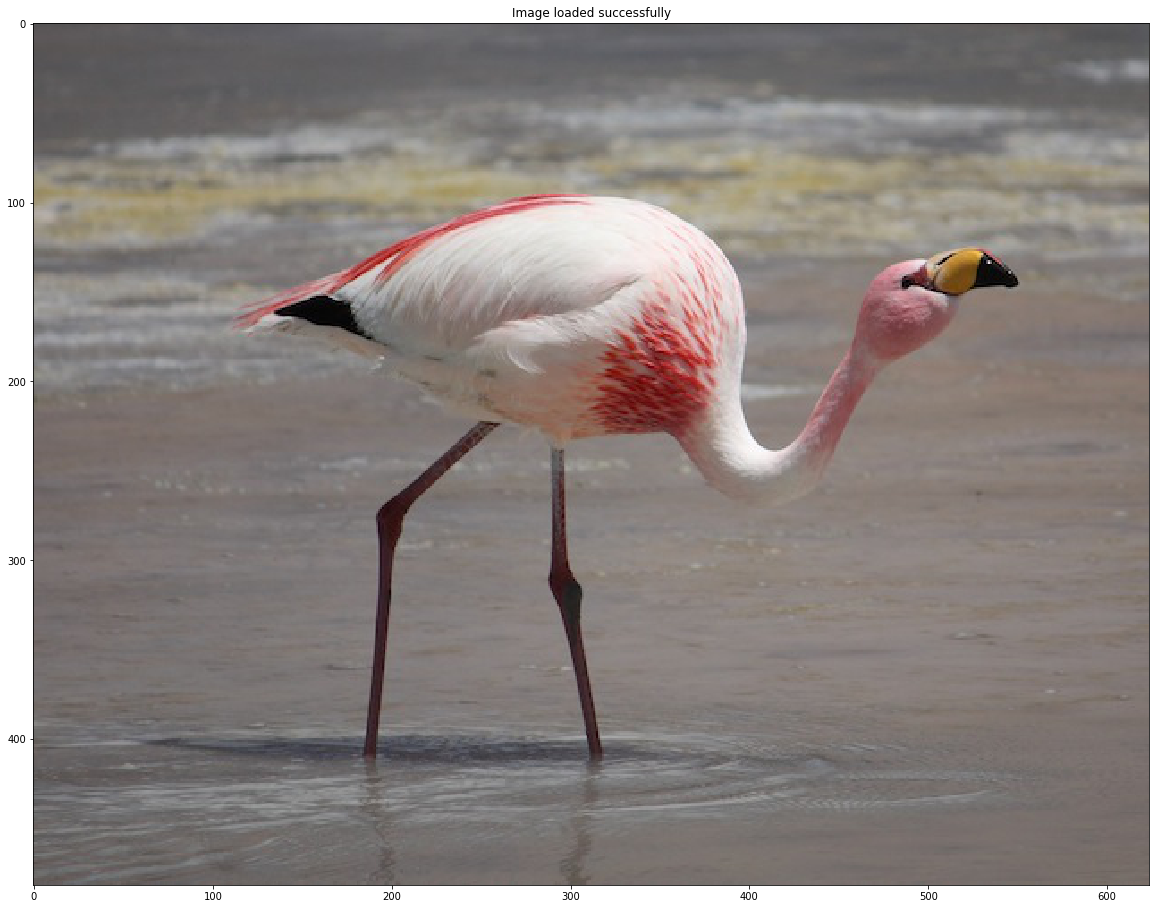

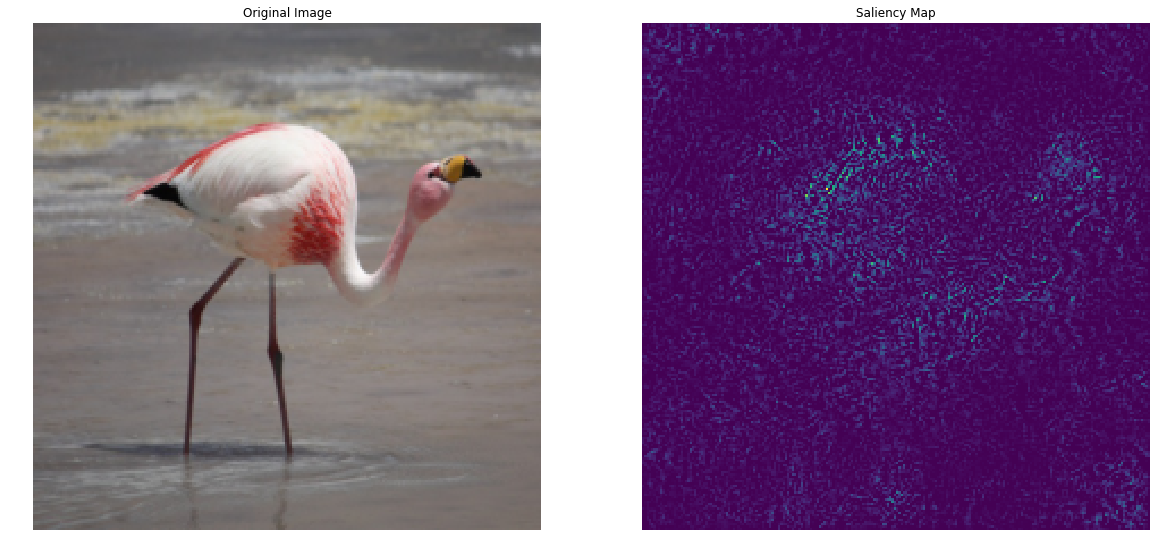

In [43]:
flamingo = load_image('images/flamingo.jpg')
flamingo_sal = make_saliency_map(flamingo, 130)

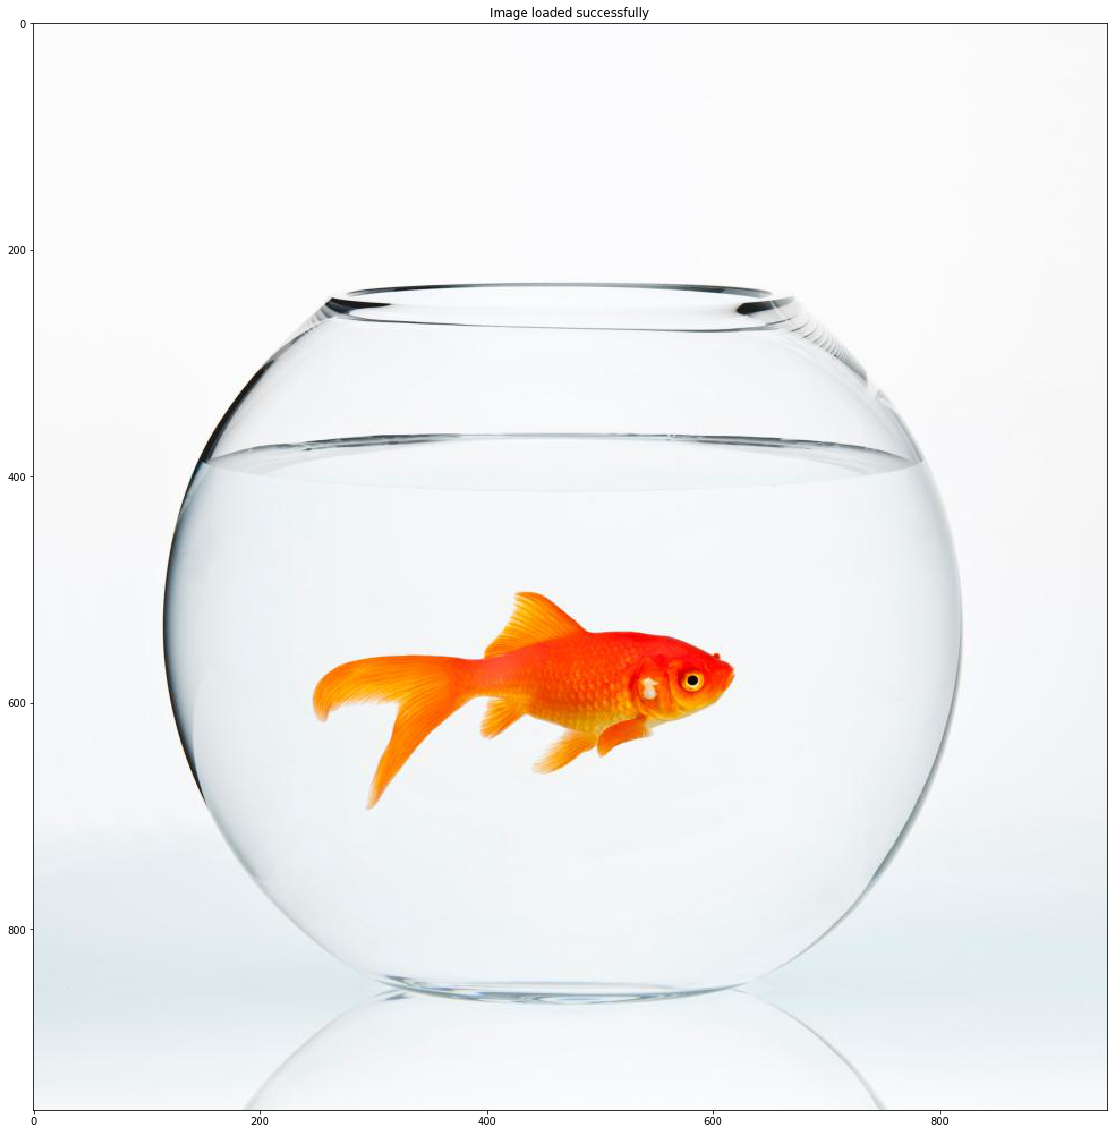

In [44]:
goldfish = load_image('images/goldfish.jpg')
goldfish_sal = make_saliency_map(goldfish, 1)

# SmoothGrad

In [45]:
def smooth_grad(input, label, x=10, percent_noise=10):
    tensor_input = torch.from_numpy(np.array(input)).type(torch.FloatTensor) # input is now of shape (w,h,c)
    # x is the sample size
    final_grad = torch.zeros((1,3,224,224))
    for i in range(x):
        print('Sample:', i+1)
        temp_input = tensor_input
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.max() - tensor_input.min()), size=temp_input.shape)).type(torch.FloatTensor)
        temp_input = (temp_input + noise).numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8))
        temp_input = Variable(preprocess(temp_input).unsqueeze(0), requires_grad=True)

        output = vgg.forward(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.numpy(), axis=2)
    
    true_image = normalize(input)
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image.data)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20
Sample: 21
Sample: 22
Sample: 23
Sample: 24
Sample: 25
Sample: 26
Sample: 27
Sample: 28
Sample: 29
Sample: 30


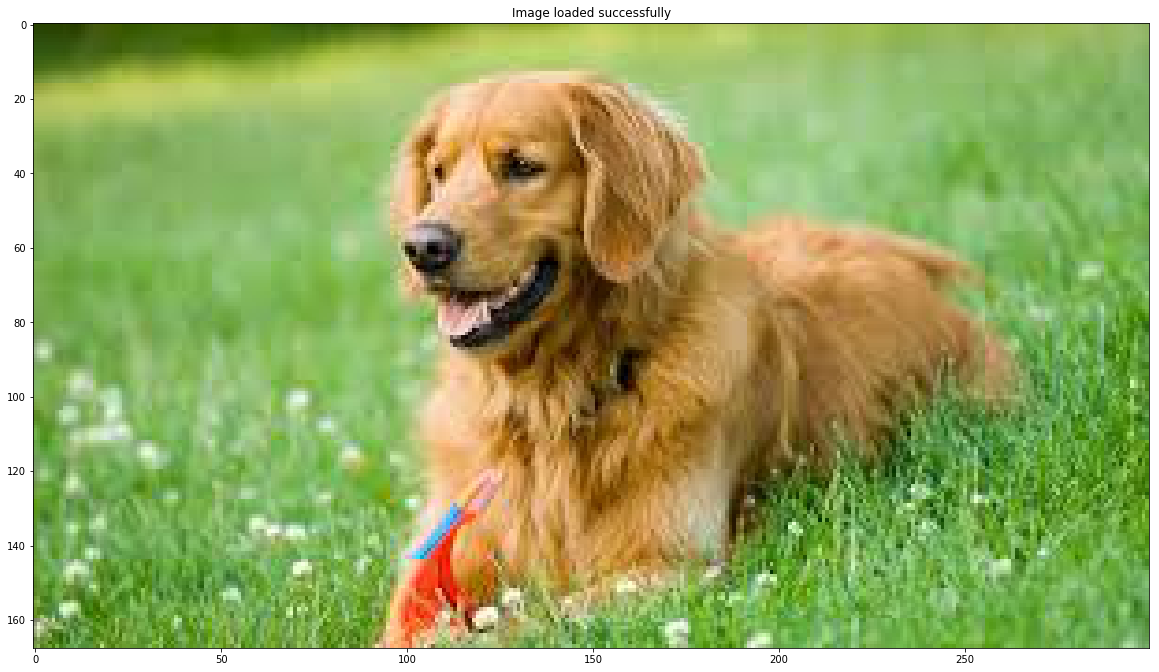

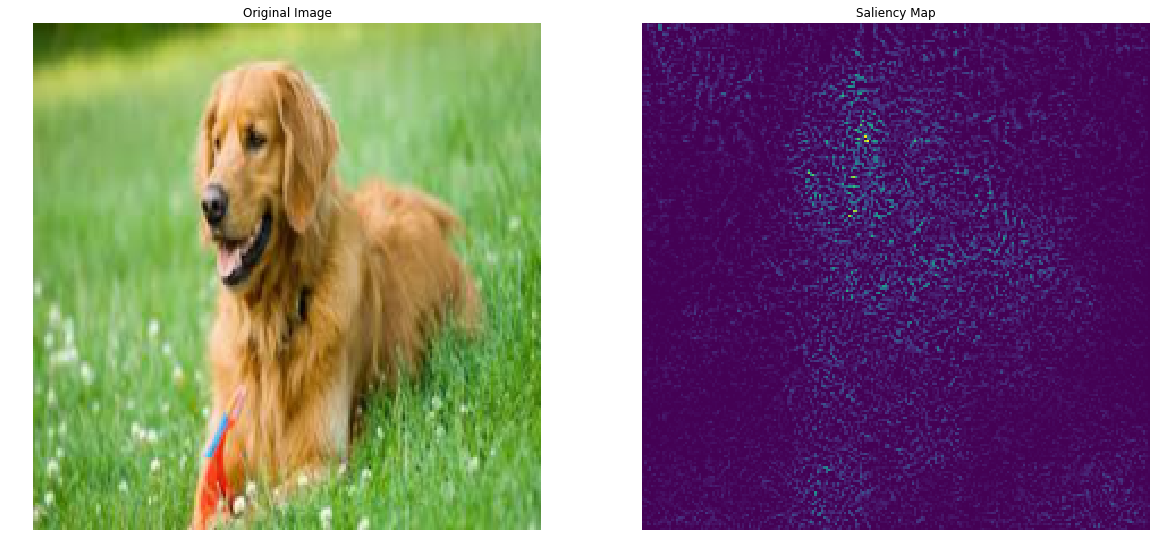

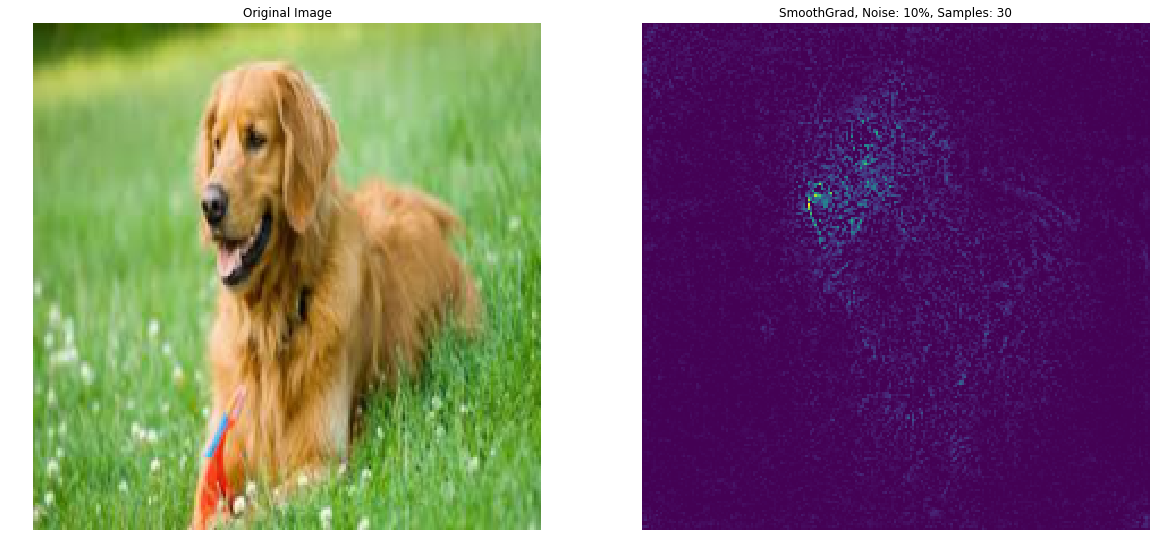

In [46]:
dog_sg = load_image('images/retr.jpeg')
dog_sal = make_saliency_map(dog_sg, 1)
dog_sg_sal = smooth_grad(dog, 207, 30, 10)

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20
Sample: 21
Sample: 22
Sample: 23
Sample: 24
Sample: 25
Sample: 26
Sample: 27
Sample: 28
Sample: 29
Sample: 30


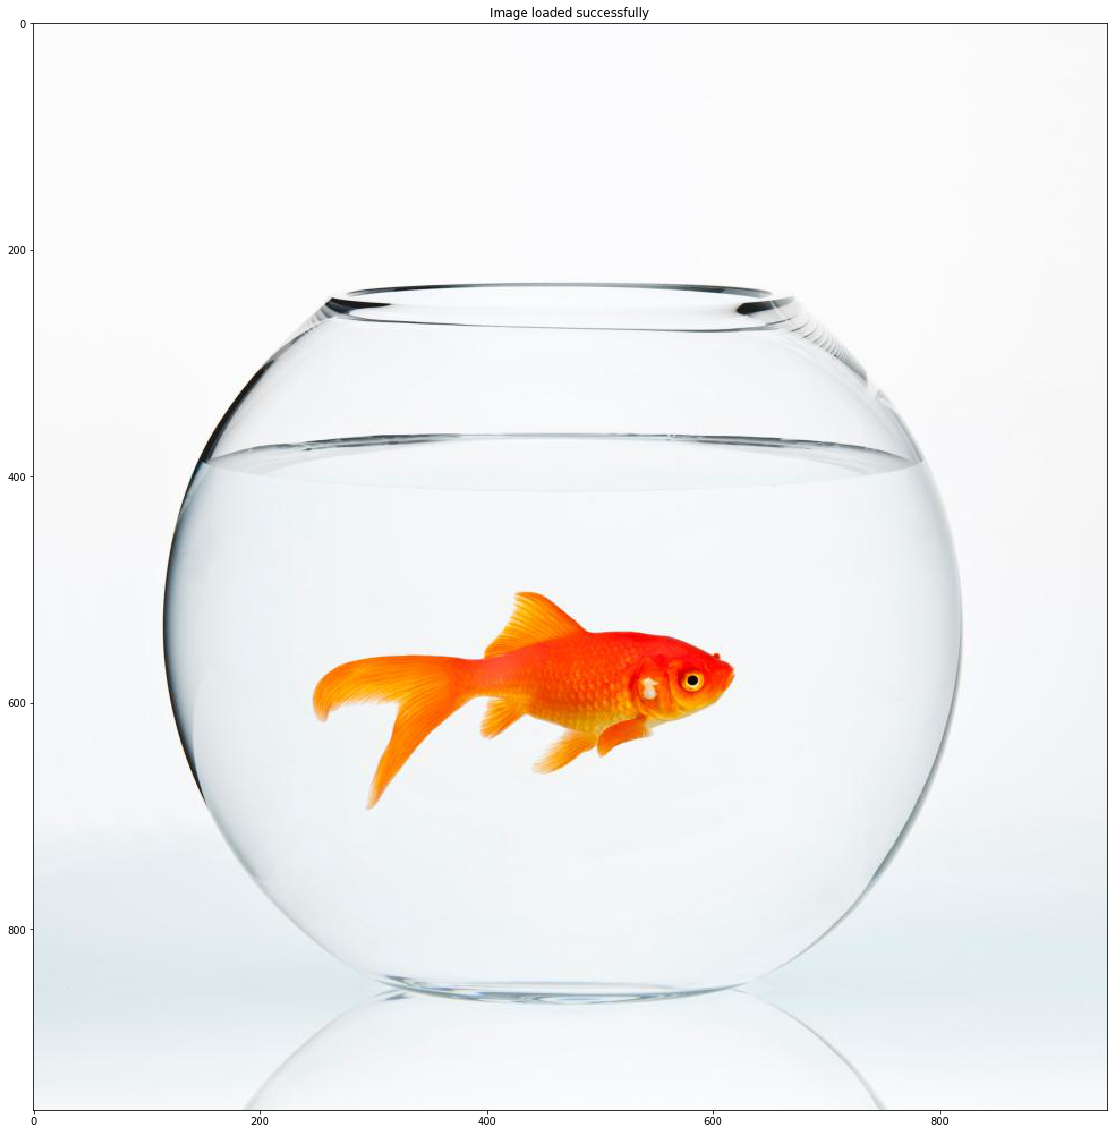

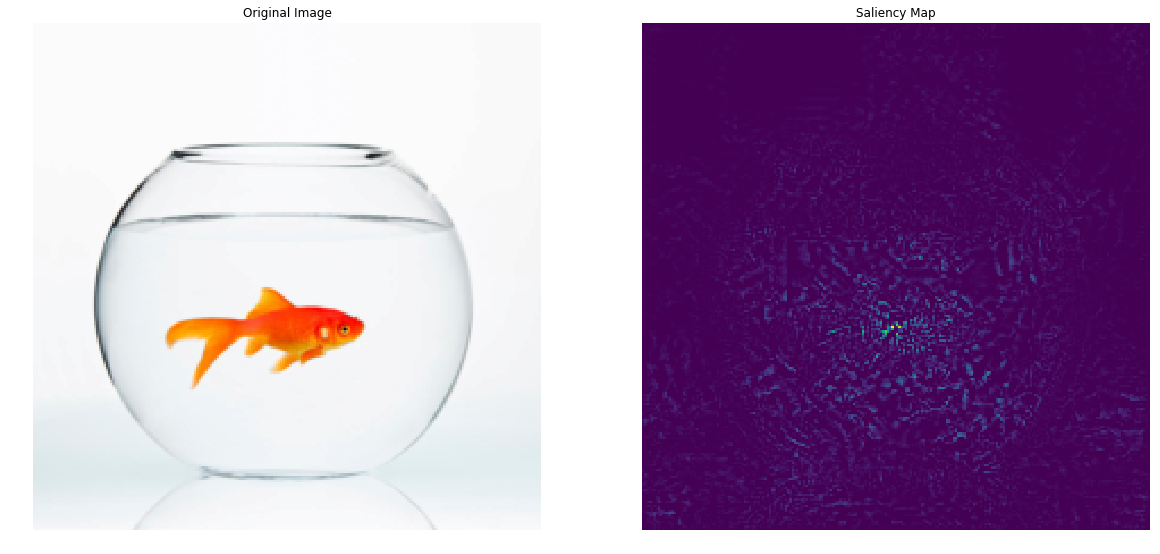

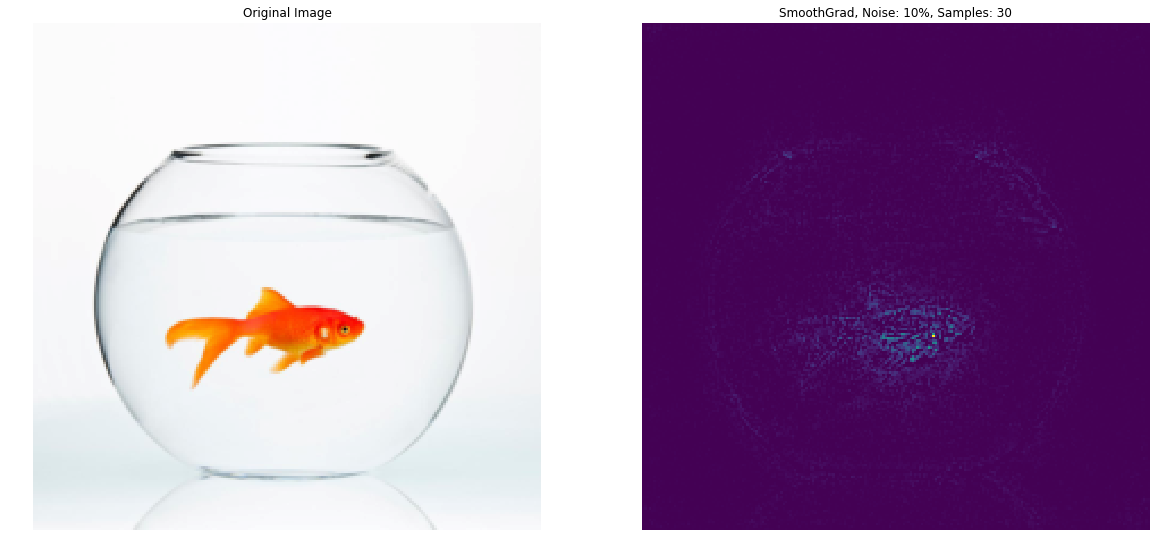

In [47]:
goldfish_sg = load_image('images/goldfish.jpg')
godlfish_sal = make_saliency_map(goldfish_sg, 1)
goldfish_sg_sal = smooth_grad(goldfish, 1, 30, 10)

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20


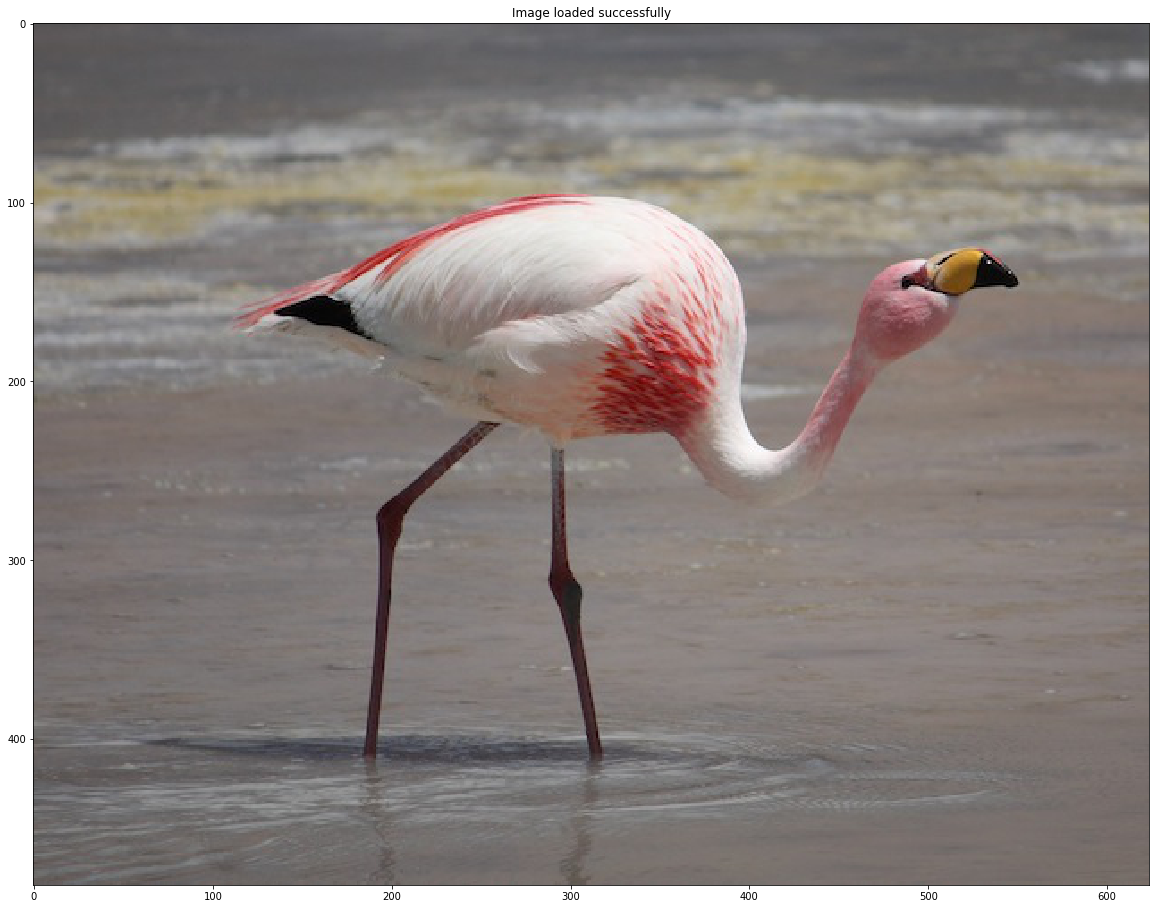

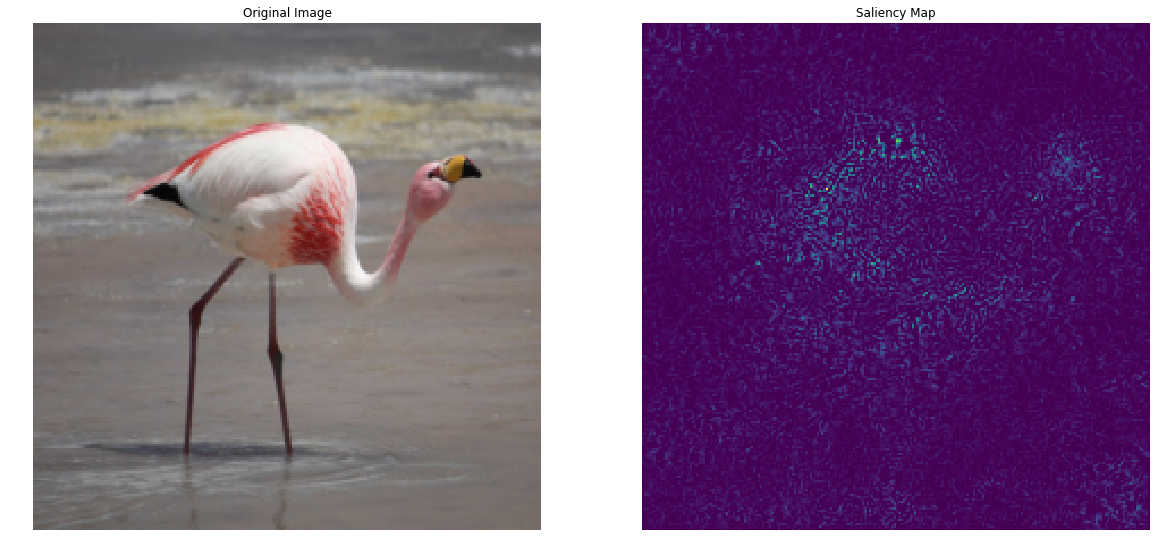

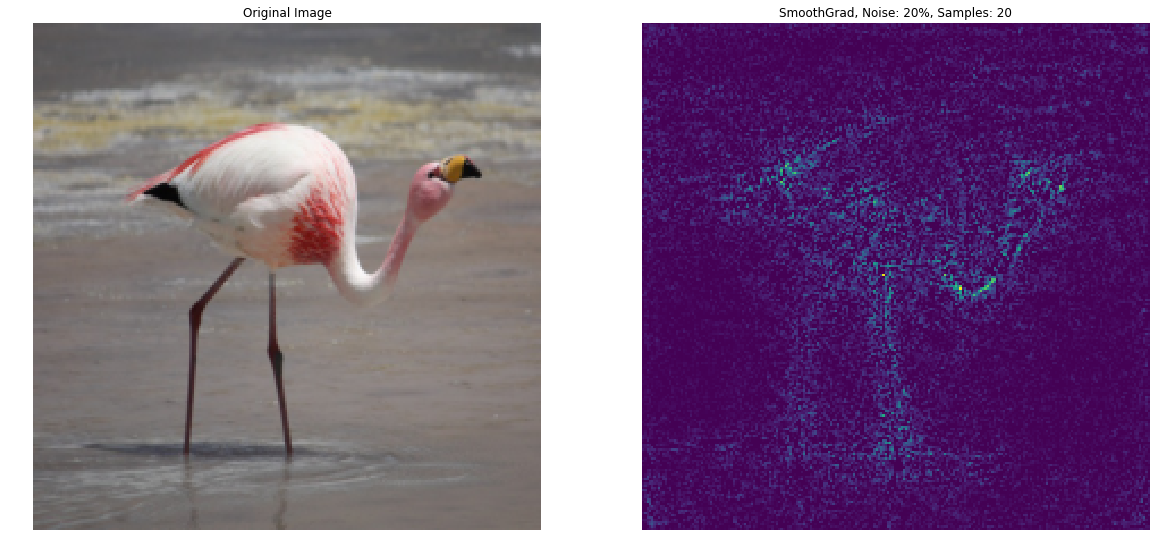

In [48]:
flamingo_sg = load_image('images/flamingo.jpg')
flamingo_sal = make_saliency_map(flamingo_sg, 130)
flamingo_sg_sal = smooth_grad(flamingo_sg, 130, 20, 20)